# Предсказание цен на недвижимость

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.image as img
matplotlib.rcParams.update({'font.size':14})
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

#### Описание датасета  

Id - идентификационный номер квартиры  
DistrictId - идентификационный номер района  
Rooms - количество комнат  
Square - площадь  
LifeSquare - жилая площадь  
KitchenSquare - площадь кухни  
Floor - этаж  
HouseFloor - количество этажей в доме  
HouseYear - год постройки дома  
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности  
Social_1, Social_2, Social_3 - социальные показатели местности  
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья  
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров  
Price - цена квартиры  


#### указание пути к файлам

In [3]:
TEST = 'test.csv'
TRAIN = 'train.csv'
TEST_PREP = 'preptest.csv'
TRAIN_PREP = 'preptrain.csv'

##### создание датафрейма для обработки

In [4]:
df = pd.read_csv(TRAIN)

In [5]:
df_test = pd.read_csv(TEST)

In [6]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [9]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обработка исходных данных

#### Исключаем признак ID

In [10]:
df = df[df.columns[1:]]

#### Поиск пустых значений

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(8), object(3)
memory usage: 1.4+ MB


In [12]:
##df.loc[df['Healthcare_1'].isnull(),'Healthcare_1'] = df['Healthcare_1'].mode()[0]

In [13]:
df.drop('Healthcare_1', axis=1, inplace=True)

In [14]:
df.loc[df['Rooms'] == 0 ,'Rooms'] = df['Rooms'].mode()[0]

In [15]:
df.loc[df['Rooms'].isnull(),'Rooms'] = df['Rooms'].mode()[0]

In [16]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] =  df['LifeSquare'].median()

In [17]:
df.loc[df['HouseYear'] > 2019, 'HouseYear'] = df['HouseYear'].mode()[0]

In [18]:
##df.loc[df['HouseFloor'] > 90, 'HouseFloor'] = df['Floor'].mode()[0]

In [19]:
df.loc[df['Floor'] > df['HouseFloor'],'HouseFloor'] = df['Floor']

In [20]:
df['HouseFloor'].median()

14.0

In [21]:
##df.loc[df['Healthcare_1'].isnull(),'Healthcare_1'] = df['Healthcare_1'].mode()[0] 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 1.4+ MB


In [23]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.892100,56.315775,36.266040,6.273300,8.526700,13.435700,1984.782100,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399
std,43.587592,0.837811,21.058732,76.609981,28.560917,5.241148,6.094012,18.349177,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865
min,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,25.527399,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,41.427234,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2019.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


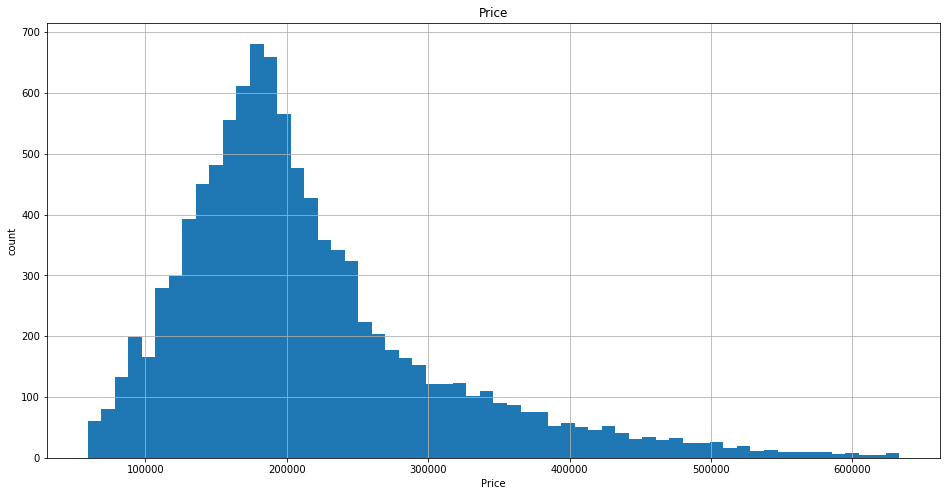

In [24]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=60)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Price')
plt.show()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(7), int64(8), object(3)
memory usage: 1.4+ MB


In [26]:
df['Helthcare_2'] = df['Helthcare_2'].astype(object)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null object
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(7), int64(7), object(4)
memory usage: 1.4+ MB


##### Приведение к бинарным признакам

In [28]:
df = pd.concat([df, pd.get_dummies(df[['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2']])], axis=1)

In [29]:
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Ecology_3_B,Shops_2_A,Shops_2_B,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,...,1,0,1,1,0,0,0,0,0,0
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,...,1,0,1,0,1,0,0,0,0,0
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,...,1,0,1,0,1,0,0,0,0,0
3,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,...,1,0,1,1,0,0,0,0,0,0
4,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,50.401785,30.476203,5.0,6,6.0,1968,0.135650,B,...,1,0,1,0,0,0,1,0,0,0
9996,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,...,1,1,0,1,0,0,0,0,0,0
9997,27,1.0,47.939008,32.781260,1.0,12,16.0,2015,0.072158,B,...,1,1,0,1,0,0,0,0,0,0
9998,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,...,0,0,1,0,0,1,0,0,0,0


#### Отбор признаков

In [30]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'Helthcare_2_0',
 'Helthcare_2_1',
 'Helthcare_2_2',
 'Helthcare_2_3',
 'Helthcare_2_4',
 'Helthcare_2_5',
 'Helthcare_2_6']

In [31]:
feature_names =['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 #'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',


 'Ecology_2_A',

 'Ecology_3_A',

 'Shops_2_A',

 'Helthcare_2_0',
 'Helthcare_2_1',
 'Helthcare_2_2',
 'Helthcare_2_3',
 'Helthcare_2_4',
 'Helthcare_2_5']

In [32]:
target_name = 'Price'

In [33]:
df = df[feature_names + [target_name]]
df.head()

KeyError: "['Healthcare_1'] not in index"

#### Стандартизация признаков

In [ ]:
df.info()

In [ ]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

In [ ]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [ ]:
stand_features

In [ ]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [ ]:
df.head(20)

#### Матрица корреляций

In [ ]:
plt.figure(figsize = (19,19))

sns.set(font_scale=1.1)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix  ')
plt.show()

#### Сохранение обработанного обучающего датасета в csv

In [ ]:
df.to_csv(TEST_PREP, index=False, encoding='utf-8')

#### Разбиение на train и test

In [ ]:
x = df[feature_names]
y = df[target_name]

In [ ]:
x

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)

## Построение базовых моделей и выбор лучшей

#### Линейная регрессия

In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

In [ ]:
y_train_preds = lr_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = lr_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)

In [ ]:
plt.barh(x_train.columns, lr_model.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')

#### Случайный лес

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

In [ ]:
y_train_preds = rf_model.predict(x_train)
evaluate_preds(y_train, y_train_preds)

In [ ]:
y_test_preds = rf_model.predict(x_test)
evaluate_preds(y_test, y_test_preds)